In [1]:
import os, sys
import pandas as pd
import numpy as np

import  CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI
import psychrolib as psylib
psylib.SetUnitSystem(psylib.SI)

In [2]:
sys.path.insert(0, os.path.join('.','..','..','calibration'))
from thermodynamics import *

# import code of mathieu
import media_model_mgcl2 as model_mg
import media_model_water as model_w

In [3]:
def read_exp_data(data_path):
    data = pd.read_csv(data_path, index_col=0)
    return data

# **dempav conversion**

In [5]:
df_exp_dempav_raw = read_exp_data("../../exp_data/raw/raw_data_20_Aug_converted.csv")

In [6]:
df_exp_dempav_raw.head()

,t_air_in,hr_air_in,m_air,t_des_in,x_des_in,m_des,t_air_out,hr_air_out,t_des_out,w_air_in,w_air_out
1,298.02,48.26,0.018848,287.44,0.318302,0.102670,290.21,47.90,286.230,0.009439,0.005762
2,300.51,55.58,0.036283,292.20,0.318186,0.102670,294.81,54.06,290.092,0.012659,0.008699
3,298.02,46.07,0.032644,284.16,0.318572,0.102670,287.98,50.83,281.766,0.009005,0.005298
4,301.31,50.70,0.036150,290.94,0.318174,0.102669,293.69,52.19,288.468,0.012089,0.007829
5,299.87,42.59,0.045742,290.34,0.318171,0.102668,292.89,52.75,288.366,0.009293,0.007528


In [ ]:
convert_to_x = lambda T, hr: psylib.GetHumRatioFromRelHum(TDryBulb=T-273.15, RelHum=hr/100, Pressure=101325)
df_exp_dempav_raw['x_a_in'] = np.vectorize(convert_to_x)(df_exp_dempav_raw.t_air_in, df_exp_dempav_raw.hr_air_in)
df_exp_dempav_raw["x_a_o_exp"] = np.vectorize(convert_to_x)(df_exp_dempav_raw.t_air_out, df_exp_dempav_raw.hr_air_out)
df_raw_dempav['x_d_in_equ'] = np.vectorize(calc_x_des_equ)(df_raw_dempav.T_d_in, df_raw_dempav.xi_d_in)

In [ ]:
df_exp_dempav = df_exp_dempav_raw.rename(columns={"t_air_in":"T_a_in", \
                                                  "t_air_out":"T_a_o_exp", \
                                                  "t_des_in":"T_d_in", \
                                                  "t_des_out":"T_d_o_exp", \
                                                 "m_air":"m_a_in", \
                                                 "m_des": "m_d_in", \
                                                 "x_des_in": "xi_d_in", \
                                                    })

In [ ]:
# df_exp_dempav.to_excel("dempav_results_Aug_final_2020.xlsx")

## calculate T_des_out using heat balance

In [23]:
df_dempav = pd.read_excel("../../exp_data/archiv/dempav_results_Aug_final_2020.xlsx", index_col=0)

In [24]:
# df_dempav["m_a_cond"] = df_dempav.m_a_in * (df_dempav.x_a_in - df_dempav.x_a_o_exp)
df_dempav_plus = prepare_for_h_m(df_dempav.copy(), type_des="MgCl2")

In [25]:
calc_T_d_out_heat_balance = lambda Q, m, T_in, xi: Q/1000/(model_mg.cp_MgCl2(T_in, xi) * m) + T_in

In [26]:
df_dempav_plus['T_d_o_exp'] = np.vectorize(calc_T_d_out_heat_balance)(df_dempav_plus.delta_Q_a,
                                                                      df_dempav_plus.m_d_in,
                                                                      df_dempav_plus.T_d_in, 
                                                                      df_dempav_plus.xi_d_in)

In [29]:
df_dempav_output = df_dempav_plus[df_dempav.columns.to_numpy()]
df_dempav_output.to_excel('../../exp_data/dempav_T_des_corrected.xlsx')

# **Teststand**

## convert raw data table

In [4]:
df_raw = pd.read_excel("../../exp_data/raw/teststand_results_old.xlsx", index_col=0, header=[0,1])
df_raw.columns = df_raw.columns.droplevel(1)
df_raw.shape

(62, 16)

In [5]:
df_raw.m_a_in = df_raw.V_a_in * np.vectorize(get_rho_dry)(df_raw.T_a_in+273.15, df_raw.hr_air_in/100) / 3600

In [6]:
df_raw.x_a_in = np.vectorize(get_x)(df_raw.T_a_in+273.15, df_raw.hr_air_in/100)

In [7]:
df_raw.x_a_o_exp = np.vectorize(get_x)(df_raw.T_a_o_exp+273.15, df_raw.hr_air_out/100)

In [8]:
df_raw.xi_d_in = np.vectorize(model_mg.xi_MgCl2)(df_raw.T_a_in+273.15, df_raw.rho_d_in)

In [9]:
df_raw.T_a_in = df_raw.T_a_in + 273.15
df_raw.T_d_in = df_raw.T_d_in + 273.15
df_raw.T_a_o_exp = df_raw.T_a_o_exp + 273.15
df_raw.T_d_o_exp = df_raw.T_d_o_exp + 273.15

In [10]:
df_raw.m_d_in = df_raw.V_d_in/1000/60 * df_raw.rho_d_in

In [11]:
df_raw['x_d_in_equ'] = np.vectorize(calc_x_des_equ)(df_raw.T_d_in, df_raw.xi_d_in)

In [12]:
df_raw.drop(columns=['w_air_in', 'w_air_out'], inplace = True)

In [13]:
df_raw.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
0,297.04,87.20,46.52,0.014969,298.21,0.313764,1.31,1292.0,0.028209,301.27,51.24,298.84,0.016362,0.012271,0.009253
1,299.92,79.81,47.22,0.015014,300.91,0.311185,1.28,1289.0,0.027499,303.40,50.93,301.59,0.017815,0.013828,0.011082
2,299.94,83.82,19.50,0.006191,300.29,0.314032,1.18,1292.0,0.025409,303.52,49.44,300.98,0.018759,0.013509,0.010496
3,300.49,75.69,18.49,0.005871,301.85,0.312199,0.75,1290.0,0.016125,304.04,46.88,302.48,0.017460,0.013190,0.011662
4,301.58,86.59,18.90,0.005943,303.40,0.312333,0.22,1290.0,0.004730,306.72,49.14,304.58,0.021418,0.016161,0.012790


## split to absorption and regeneration

In [14]:
df_raw.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
0,297.04,87.20,46.52,0.014969,298.21,0.313764,1.31,1292.0,0.028209,301.27,51.24,298.84,0.016362,0.012271,0.009253
1,299.92,79.81,47.22,0.015014,300.91,0.311185,1.28,1289.0,0.027499,303.40,50.93,301.59,0.017815,0.013828,0.011082
2,299.94,83.82,19.50,0.006191,300.29,0.314032,1.18,1292.0,0.025409,303.52,49.44,300.98,0.018759,0.013509,0.010496
3,300.49,75.69,18.49,0.005871,301.85,0.312199,0.75,1290.0,0.016125,304.04,46.88,302.48,0.017460,0.013190,0.011662
4,301.58,86.59,18.90,0.005943,303.40,0.312333,0.22,1290.0,0.004730,306.72,49.14,304.58,0.021418,0.016161,0.012790


In [17]:
df_raw_cool = df_raw.query('T_a_in - T_d_in>5')
df_raw_cool.shape

(30, 15)

In [28]:
df_raw_absorption = df_raw.query('x_a_in > x_a_o_exp')
df_raw_absorption.shape

(58, 15)

In [36]:
df_raw_regeneration

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
17,304.65,12.55,69.81,0.022346,309.03,0.310888,1.31,1288.0,0.028121,302.62,28.18,307.20,0.003601,0.007240,0.017959
31,308.69,20.16,62.51,0.019631,311.41,0.314454,1.34,1291.0,0.028832,306.34,32.53,310.19,0.007294,0.010378,0.020168
32,306.20,32.67,62.51,0.019696,311.06,0.313041,1.24,1290.0,0.026660,307.20,38.06,308.45,0.010340,0.012789,0.019933
38,309.92,13.89,78.85,0.024740,309.67,0.309998,1.34,1286.0,0.028721,306.03,28.63,308.28,0.005360,0.008956,0.018731


In [30]:
df_raw_regeneration = df_raw.query('x_a_in < x_a_o_exp')
df_raw_regeneration.shape

(4, 15)

In [33]:
df_raw.query('x_d_in_equ>x_a_in')

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
17,304.65,12.55,69.81,0.022346,309.03,0.310888,1.31,1288.0,0.028121,302.62,28.18,307.20,0.003601,0.007240,0.017959
31,308.69,20.16,62.51,0.019631,311.41,0.314454,1.34,1291.0,0.028832,306.34,32.53,310.19,0.007294,0.010378,0.020168
32,306.20,32.67,62.51,0.019696,311.06,0.313041,1.24,1290.0,0.026660,307.20,38.06,308.45,0.010340,0.012789,0.019933
38,309.92,13.89,78.85,0.024740,309.67,0.309998,1.34,1286.0,0.028721,306.03,28.63,308.28,0.005360,0.008956,0.018731


In [41]:
df_raw_heat = df_raw.query('T_d_in-T_a_in > 2')

In [42]:
df_raw_heat

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp,x_d_in_equ
11,300.22,79.59,16.35,0.005191,304.63,0.299788,1.44,1277.0,0.030648,304.73,47.42,304.85,0.018089,0.013891,0.014773
12,300.80,73.22,16.45,0.005220,304.67,0.299861,0.68,1277.0,0.014473,304.59,47.67,304.97,0.017193,0.013853,0.014802
17,304.65,12.55,69.81,0.022346,309.03,0.310888,1.31,1288.0,0.028121,302.62,28.18,307.20,0.003601,0.007240,0.017959
21,301.47,82.73,20.41,0.006431,303.90,0.311371,0.16,1289.0,0.003437,306.62,47.75,305.30,0.020298,0.015602,0.013252
22,302.13,84.09,31.33,0.009833,304.40,0.311458,0.16,1289.0,0.003437,307.41,49.43,306.09,0.021476,0.016914,0.013645
23,301.04,87.26,30.88,0.009735,304.84,0.309419,0.37,1287.0,0.007936,306.48,50.26,306.78,0.020899,0.016312,0.014172
24,301.71,86.25,31.16,0.009793,305.35,0.309506,0.65,1287.0,0.013943,306.87,50.31,306.31,0.021499,0.016699,0.014599
25,301.77,72.59,44.56,0.014076,305.74,0.309513,0.20,1287.0,0.004290,305.55,48.44,306.65,0.018060,0.014887,0.014938
26,302.78,85.64,31.56,0.009864,306.34,0.304905,0.20,1282.0,0.004273,308.21,50.33,308.42,0.022753,0.018035,0.015885
28,302.14,88.91,19.17,0.006004,306.46,0.303860,0.25,1281.0,0.005338,308.44,48.34,308.99,0.022766,0.017530,0.016091


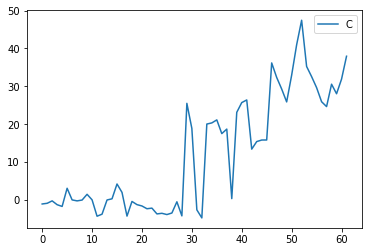

In [37]:
(df_raw.T_a_in - df_raw.T_d_in).plot()

In [43]:
calc_x_des_equ(T_des=311.06, xi_des = 0.313, type_desiccant='LiCl')

0.016598107787442144

In [44]:
calc_x_des_equ(T_des=311.06, xi_des = 0.313, type_desiccant='MgCl2')

0.019937677174607284

# **ZHAW**